In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
img_size = 256
input_shape = (32,img_size,img_size,3)
batch_size = 32
chanels = 3
epochs = 60
num_class = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (img_size, img_size),
    batch_size = batch_size,   
)

Found 2152 files belonging to 3 classes.


In [4]:
class_name = dataset.class_names
print(class_name)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [5]:
len(dataset)

68

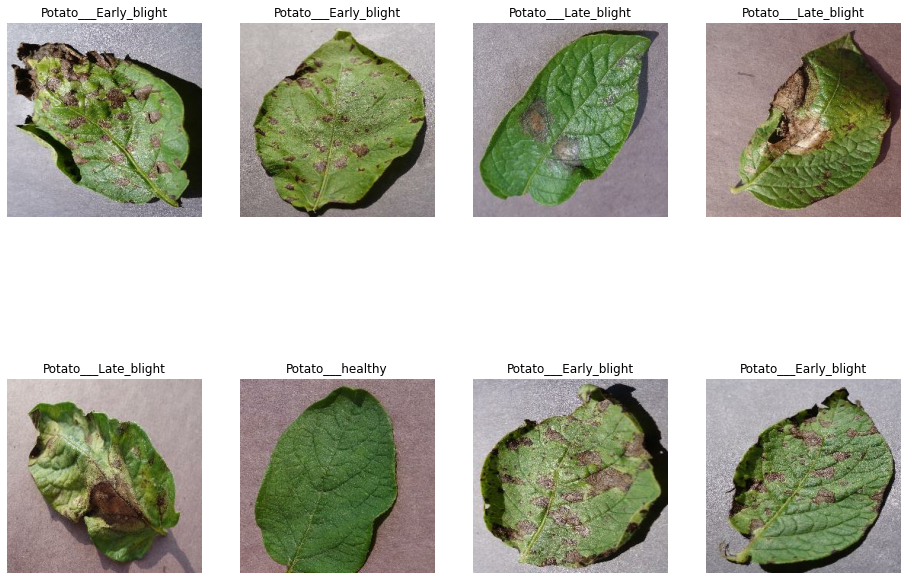

In [6]:
plt.figure(figsize=(16,12))
for image_batch, label_batch in dataset.take(1):
    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")
    

In [7]:
def split_data(data, train = 0.8 , val = 0.1, test = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(data)
    if shuffle:
        data = data.shuffle(shuffle_size)
    train_sz = int(train*ds_size)
    train_ds = data.take(train_sz)
    tmp = data.skip(train_sz)
    
    val_sz = int(val*ds_size)
    val_ds = tmp.take(val_sz)
    test_ds = tmp.skip(val_sz)
    return train_ds, val_ds, test_ds

In [8]:
train, val, test = split_data(dataset) 

In [9]:
train = train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val = train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [10]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size, img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [12]:
model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    layers.Dense(num_class, activation = "softmax")
])
model.build(input_shape = input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [14]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [15]:
history = model.fit(
    train,
    epochs = epochs,
    batch_size = batch_size,
    verbose = 1,
    validation_data = val
)

Epoch 1/60
54/54 [==============================] - 116s 2s/step - loss: 0.8778 - accuracy: 0.5329 - val_loss: 0.7569 - val_accuracy: 0.7119
Epoch 2/60
54/54 [==============================] - 113s 2s/step - loss: 0.6298 - accuracy: 0.7271 - val_loss: 0.4358 - val_accuracy: 0.8281
Epoch 3/60
54/54 [==============================] - 114s 2s/step - loss: 0.3677 - accuracy: 0.8492 - val_loss: 0.2796 - val_accuracy: 0.8950
Epoch 4/60
54/54 [==============================] - 114s 2s/step - loss: 0.2708 - accuracy: 0.8897 - val_loss: 0.2128 - val_accuracy: 0.9131
Epoch 5/60
54/54 [==============================] - 115s 2s/step - loss: 0.2912 - accuracy: 0.8809 - val_loss: 0.2137 - val_accuracy: 0.9184
Epoch 6/60
54/54 [==============================] - 116s 2s/step - loss: 0.2163 - accuracy: 0.9149 - val_loss: 0.1665 - val_accuracy: 0.9349
Epoch 7/60
54/54 [==============================] - 115s 2s/step - loss: 0.1894 - accuracy: 0.9225 - val_loss: 0.9641 - val_accuracy: 0.6749
Epoch 8/60
54

Epoch 59/60
54/54 [==============================] - 111s 2s/step - loss: 0.0289 - accuracy: 0.9871 - val_loss: 0.0620 - val_accuracy: 0.9789
Epoch 60/60
54/54 [==============================] - 111s 2s/step - loss: 0.0114 - accuracy: 0.9965 - val_loss: 0.0313 - val_accuracy: 0.9894


In [16]:
scores = model.evaluate(test)

8/8 [==============================] - 10s 384ms/step - loss: 0.0415 - accuracy: 0.9844


In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

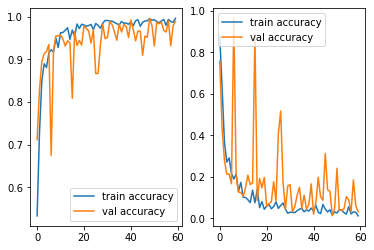

In [18]:
plt.subplot(1,2,1)
plt.plot(range(epochs), acc, label = 'train accuracy')
plt.plot(range(epochs), val_acc, label = 'val accuracy')
plt.legend(loc = 'lower right')

plt.subplot(1,2,2)
plt.plot(range(epochs), loss, label = 'train accuracy')
plt.plot(range(epochs), val_loss, label = 'val accuracy')
plt.legend(loc = 'upper left')

first image to predict
actual label :  Potato___Late_blight
1/1 [==============================] - 2s 2s/step
predicted label :  Potato___Late_blight


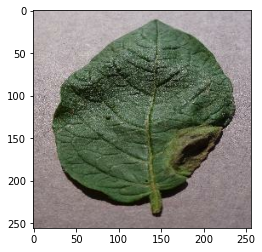

In [19]:
for images_batch , labels_batch in test.take(1):
    first_img = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0]
    print("first image to predict")
    plt.imshow(first_img)
    print("actual label : ", class_name[first_label.numpy()])
    
    batch_pred = model.predict(images_batch)
    print("predicted label : ",class_name[np.argmax(batch_pred[0])])

In [20]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)
    
    predd = model.predict(img_array)
    predd_class = class_name[np.argmax(predd[0])]
    confidence = round(100 * (np.max(predd[0])), 2)
    return predd_class, confidence

1/1 [==============================] - 0s 29ms/step


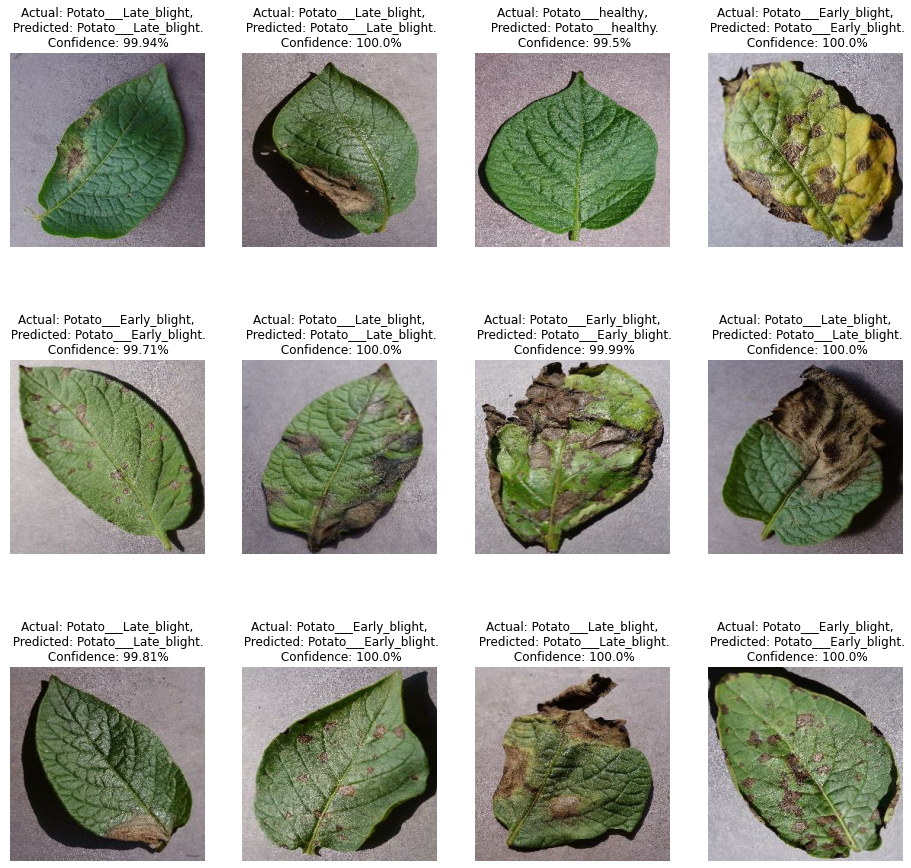

In [21]:
plt.figure(figsize = (16,16))
for imgs, labels in test.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(imgs[i].numpy().astype("uint8"))
        plt.axis("off")
        predd_class, confidence = predict(model, imgs[i].numpy())
        main_class = class_name[labels[i]]
        plt.title(f"Actual: {main_class},\n Predicted: {predd_class}.\n Confidence: {confidence}%")


In [22]:
model_version = 1.0
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1.0\assets


INFO:tensorflow:Assets written to: ../models/1.0\assets
